# PRO GAN

In [1]:
# !pip install -q kaggle tensorboard scipy
# !mkdir ~/.kaggle
# !cp /teamspace/uploads/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces

# import shutil
# shutil.unpack_archive('140k-real-and-fake-faces.zip')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from math import log2
from scipy.stats import truncnorm
import random
import numpy as np
import os
import datetime
from PIL import Image
torch.manual_seed(69)

## Config

In [3]:
os.makedirs("models", exist_ok=True)
class Config:
    START_TRAIN_AT_IMG_SIZE = 4
    DATASET = 'real_vs_fake/real-vs-fake/train'
    CHECKPOINT_GEN = "models/pro_generator_128_2.pth"
    CHECKPOINT_CRITIC = "models/pro_critic_128_2.pth"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SAVE_MODEL = True
    LOAD_MODEL = False
    LEARNING_RATE = 1e-3
    BATCH_SIZES = [128, 128, 64, 32, 16, 8]
    FACTORS = [1, 1/2, 1/4, 1/8, 1/16, 1/32]
    CHANNELS_IMG = 3
    Z_DIM = 256
    IN_CHANNELS = 512
    LAMBDA_GP = 10
    PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)
    FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
    NUM_WORKERS = 8
    TRAIN_SUBSET_SIZE = 25000

config = Config()

## Model

In [4]:
class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        # Converts n channel image to rgb channel
        self.initial_vec_to_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )

        self.prog_blocks, self.vec_to_rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_vec_to_rgb]),
        )

        for i in range(
            len(config.FACTORS) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * config.FACTORS[i])
            conv_out_c = int(in_channels * config.FACTORS[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.vec_to_rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * generated + (1 - alpha) * upscaled

    def forward(self, x, alpha, steps):
        out = self.initial(x) # 1x1 to 4x4

        if steps == 0:
            return self.initial_vec_to_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different vec_to_rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.vec_to_rgb_layers[steps - 1](upscaled)
        final_out = self.vec_to_rgb_layers[steps](out)
        return torch.tanh(self.fade_in(alpha, final_upscaled, final_out))

In [5]:
class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_to_vec_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb_to_vec layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(config.FACTORS) - 1, 0, -1):
            conv_in = int(in_channels * config.FACTORS[i])
            conv_out = int(in_channels * config.FACTORS[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_to_vec_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb_to_vec" this is just the RGBto_vec layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb_to_vec
        self.initial_rgb_to_vec = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_to_vec_layers.append(self.initial_rgb_to_vec)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb_to_vec as initial step, this will depend on
        # the image size (each will have it's on rgb_to_vec layer)
        out = self.leaky(self.rgb_to_vec_layers[cur_step](x))

        if steps != 0:# i.e, image is anything other than 4x4
            # because prog_blocks might change the channels, for down scale we use rgb_to_vec_layer
            # from previous/smaller size which in our case correlates to +1 in the indexing
            downscaled = self.leaky(self.rgb_to_vec_layers[cur_step + 1](self.avg_pool(x)))
            out = self.avg_pool(self.prog_blocks[cur_step](out))

            # the fade_in is done first between the downscaled and the input
            # this is opposite from the generator
            out = self.fade_in(alpha, downscaled, out)

            for step in range(cur_step + 1, len(self.prog_blocks)):
                out = self.prog_blocks[step](out)
                out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [6]:
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=3)
critic = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=3)

for img_size in [4, 8, 16, 32, 64, 128]:
    num_steps = int(log2(img_size / 4))
    x = torch.randn((1, config.Z_DIM, 1, 1))
    z = gen(x, 0.5, steps=num_steps)
    assert z.shape == (1, 3, img_size, img_size)
    out = critic(z, alpha=0.5, steps=num_steps)
    assert out.shape == (1, 1)
    print(f"Success! At img size: {img_size}")

/tmp/ipykernel_6860/1651960601.py:47: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/aten/src/ATen/native/ReduceOps.cpp:1760.)
  torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])


Success! At img size: 4
Success! At img size: 8
Success! At img size: 16
Success! At img size: 32
Success! At img size: 64
Success! At img size: 128


## Utils

In [7]:
# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss/Critic", loss_critic, global_step=tensorboard_step, new_style=True)
    writer.add_scalar("Loss/Gen", loss_gen, global_step=tensorboard_step, new_style=True)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        # img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        # writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

## Training

In [8]:
log_folder_name = f"logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}/"
os.makedirs(log_folder_name, exist_ok=True)

In [9]:
torch.backends.cudnn.benchmarks = True


def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(config.CHANNELS_IMG)],
                [0.5 for _ in range(config.CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = config.BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=config.DATASET, transform=transform)
    class_idx = dataset.class_to_idx["real"]
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    subset_indices = class_indices[:config.TRAIN_SUBSET_SIZE]
    subset_dataset = Subset(dataset, subset_indices)
    loader = DataLoader(
        subset_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        drop_last=True
    )
    return loader, dataset


def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
    log_folder_name,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(config.DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=config.DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) 
                - torch.mean(critic_fake))
                + config.LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (config.PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
            loss_gen=loss_gen.item()
        )
    
    with torch.no_grad():
        fixed_fakes = gen(config.FIXED_NOISE, alpha, step) * 0.5 + 0.5
    plot_to_tensorboard(
        writer,
        loss_critic.item(),
        loss_gen.item(),
        real.detach(),
        fixed_fakes.detach(),
        tensorboard_step,
    )
    tensorboard_step += 1
    
    os.makedirs(log_folder_name + "training", exist_ok=True)
    save_image(fixed_fakes, log_folder_name + f"training/{step}_{epoch}.png", normalize=True)

    return tensorboard_step, alpha



# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
# but really who cares..
gen = Generator(
    config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
).to(config.DEVICE)
critic = Discriminator(
    config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99)
)
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()

# for tensorboard plotting
writer = SummaryWriter(log_folder_name)

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,
    )
    load_checkpoint(
        config.CHECKPOINT_CRITIC, critic, opt_critic, config.LEARNING_RATE,
    )

gen.train()
critic.train()

tensorboard_step = 0
# start at step that corresponds to img size that we set in config
step = int(log2(config.START_TRAIN_AT_IMG_SIZE / 4))
for num_epochs in config.PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-5  # start with very low alpha
    loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        tensorboard_step, alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
            tensorboard_step,
            writer,
            scaler_gen,
            scaler_critic,
            log_folder_name,
        )

        if config.SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
            save_checkpoint(critic, opt_critic, filename=config.CHECKPOINT_CRITIC)

    step += 1  # progress to the next img size

Current image size: 4
Epoch [1/30]


100%|██████████| 195/195 [00:07<00:00, 24.92it/s, gp=0.0195, loss_critic=-.807, loss_gen=0.544]


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 195/195 [00:06<00:00, 29.24it/s, gp=0.0138, loss_critic=-.479, loss_gen=-.327]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 195/195 [00:06<00:00, 29.75it/s, gp=0.0118, loss_critic=-.266, loss_gen=0.257] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 195/195 [00:06<00:00, 29.58it/s, gp=0.00962, loss_critic=-.103, loss_gen=0.162]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 195/195 [00:06<00:00, 28.73it/s, gp=0.00907, loss_critic=0.0258, loss_gen=0.141]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 195/195 [00:06<00:00, 28.96it/s, gp=0.0111, loss_critic=0.0611, loss_gen=0.224]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 195/195 [00:06<00:00, 29.22it/s, gp=0.00807, loss_critic=-.0131, loss_gen=0.32]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 195/195 [00:06<00:00, 28.30it/s, gp=0.0122, loss_critic=0.0566, loss_gen=0.0265]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 195/195 [00:06<00:00, 29.09it/s, gp=0.00815, loss_critic=0.0926, loss_gen=0.209]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 195/195 [00:06<00:00, 29.06it/s, gp=0.0068, loss_critic=0.0305, loss_gen=0.117]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 195/195 [00:06<00:00, 28.60it/s, gp=0.00855, loss_critic=0.121, loss_gen=0.102]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 195/195 [00:06<00:00, 29.34it/s, gp=0.00384, loss_critic=-.0259, loss_gen=0.12]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 195/195 [00:06<00:00, 28.98it/s, gp=0.00697, loss_critic=0.0721, loss_gen=0.196]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 195/195 [00:06<00:00, 28.72it/s, gp=0.00461, loss_critic=-.0191, loss_gen=0.461]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 195/195 [00:06<00:00, 29.01it/s, gp=0.00451, loss_critic=0.0618, loss_gen=0.103]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 195/195 [00:06<00:00, 29.99it/s, gp=0.00654, loss_critic=0.0456, loss_gen=0.0987] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 195/195 [00:06<00:00, 28.79it/s, gp=0.00548, loss_critic=0.0266, loss_gen=0.163]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 195/195 [00:06<00:00, 29.34it/s, gp=0.00649, loss_critic=0.0799, loss_gen=0.153]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 195/195 [00:06<00:00, 28.54it/s, gp=0.00331, loss_critic=-.00105, loss_gen=0.157]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 195/195 [00:06<00:00, 28.91it/s, gp=0.00424, loss_critic=0.0938, loss_gen=0.165]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 195/195 [00:06<00:00, 29.24it/s, gp=0.00667, loss_critic=-.0574, loss_gen=-.125]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 195/195 [00:06<00:00, 29.77it/s, gp=0.00404, loss_critic=0.0262, loss_gen=-.0351] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 195/195 [00:06<00:00, 28.78it/s, gp=0.00919, loss_critic=0.121, loss_gen=0.314]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 195/195 [00:06<00:00, 28.39it/s, gp=0.0079, loss_critic=0.107, loss_gen=0.225]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 195/195 [00:06<00:00, 29.88it/s, gp=0.0138, loss_critic=0.119, loss_gen=0.112]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 195/195 [00:06<00:00, 29.35it/s, gp=0.00432, loss_critic=0.0663, loss_gen=-.136]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 195/195 [00:06<00:00, 28.38it/s, gp=0.00464, loss_critic=0.0645, loss_gen=0.159]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 195/195 [00:06<00:00, 29.68it/s, gp=0.00313, loss_critic=0.0739, loss_gen=-.03]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 195/195 [00:06<00:00, 28.62it/s, gp=0.00262, loss_critic=0.00636, loss_gen=-.0217] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 195/195 [00:06<00:00, 29.48it/s, gp=0.0052, loss_critic=0.0341, loss_gen=-.0442]   


=> Saving checkpoint
=> Saving checkpoint
Current image size: 8
Epoch [1/30]


100%|██████████| 195/195 [00:08<00:00, 22.02it/s, gp=0.00583, loss_critic=-.859, loss_gen=-1.37]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 195/195 [00:08<00:00, 22.00it/s, gp=0.0112, loss_critic=-.777, loss_gen=-.103]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 195/195 [00:08<00:00, 21.94it/s, gp=0.00599, loss_critic=0.161, loss_gen=7.24]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 195/195 [00:08<00:00, 22.52it/s, gp=0.00705, loss_critic=-.0733, loss_gen=0.275] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 195/195 [00:07<00:00, 24.45it/s, gp=0.00306, loss_critic=-.18, loss_gen=0.26]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 195/195 [00:07<00:00, 24.97it/s, gp=0.0214, loss_critic=0.439, loss_gen=1.42]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 195/195 [00:08<00:00, 22.50it/s, gp=0.00389, loss_critic=-.0229, loss_gen=-3.74] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 195/195 [00:08<00:00, 23.62it/s, gp=0.00225, loss_critic=0.147, loss_gen=0.295]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 195/195 [00:09<00:00, 21.48it/s, gp=0.00212, loss_critic=0.131, loss_gen=1.32]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 195/195 [00:08<00:00, 23.88it/s, gp=0.00454, loss_critic=0.115, loss_gen=-.128]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 195/195 [00:08<00:00, 23.13it/s, gp=0.00415, loss_critic=-.0205, loss_gen=2.2]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 195/195 [00:08<00:00, 21.68it/s, gp=0.00169, loss_critic=-.0521, loss_gen=1.24]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 195/195 [00:08<00:00, 22.71it/s, gp=0.00112, loss_critic=0.109, loss_gen=0.821]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 195/195 [00:08<00:00, 22.05it/s, gp=0.00254, loss_critic=0.0667, loss_gen=1.5]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 195/195 [00:08<00:00, 22.09it/s, gp=0.00186, loss_critic=-.0195, loss_gen=-.712] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 195/195 [00:08<00:00, 23.41it/s, gp=0.00237, loss_critic=0.259, loss_gen=1.14]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 195/195 [00:09<00:00, 21.31it/s, gp=0.00158, loss_critic=-.0812, loss_gen=0.242] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 195/195 [00:08<00:00, 21.86it/s, gp=0.00182, loss_critic=-.0378, loss_gen=-.854] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 195/195 [00:08<00:00, 22.70it/s, gp=0.00225, loss_critic=0.024, loss_gen=-1.01]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 195/195 [00:08<00:00, 22.03it/s, gp=0.00497, loss_critic=0.187, loss_gen=0.291]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 195/195 [00:09<00:00, 21.35it/s, gp=0.00442, loss_critic=0.163, loss_gen=0.191]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 195/195 [00:08<00:00, 23.41it/s, gp=0.00267, loss_critic=-.0196, loss_gen=-2.3]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 195/195 [00:08<00:00, 23.22it/s, gp=0.00612, loss_critic=0.113, loss_gen=1.06]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 195/195 [00:09<00:00, 21.43it/s, gp=0.00832, loss_critic=0.221, loss_gen=0.284]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 195/195 [00:08<00:00, 23.08it/s, gp=0.00577, loss_critic=0.327, loss_gen=-.404]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 195/195 [00:08<00:00, 23.00it/s, gp=0.00829, loss_critic=0.178, loss_gen=0.265]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 195/195 [00:08<00:00, 22.25it/s, gp=0.00382, loss_critic=0.0167, loss_gen=0.619]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 195/195 [00:08<00:00, 23.13it/s, gp=0.00528, loss_critic=0.179, loss_gen=0.671]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 195/195 [00:08<00:00, 23.87it/s, gp=0.00375, loss_critic=0.12, loss_gen=-.613]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 195/195 [00:08<00:00, 22.21it/s, gp=0.00574, loss_critic=0.157, loss_gen=0.146]    


=> Saving checkpoint
=> Saving checkpoint
Current image size: 16
Epoch [1/30]


100%|██████████| 390/390 [00:29<00:00, 13.34it/s, gp=0.0208, loss_critic=-.426, loss_gen=2.96]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 390/390 [00:29<00:00, 13.16it/s, gp=0.0124, loss_critic=-1.22, loss_gen=1.11]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 390/390 [00:29<00:00, 13.31it/s, gp=0.00255, loss_critic=-.412, loss_gen=1.78]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 390/390 [00:29<00:00, 13.34it/s, gp=0.00164, loss_critic=0.388, loss_gen=-.319]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 390/390 [00:28<00:00, 13.54it/s, gp=0.00339, loss_critic=-.0552, loss_gen=0.514]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 390/390 [00:28<00:00, 13.67it/s, gp=0.00251, loss_critic=-.265, loss_gen=-.293]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 390/390 [00:28<00:00, 13.79it/s, gp=0.0022, loss_critic=0.00154, loss_gen=0.9]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 390/390 [00:28<00:00, 13.92it/s, gp=0.00414, loss_critic=-.0756, loss_gen=-1.02] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 390/390 [00:28<00:00, 13.55it/s, gp=0.00315, loss_critic=0.208, loss_gen=-.0882]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 390/390 [00:28<00:00, 13.58it/s, gp=0.00323, loss_critic=-.0137, loss_gen=0.255]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 390/390 [00:28<00:00, 13.76it/s, gp=0.00657, loss_critic=-.343, loss_gen=1.62]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 390/390 [00:28<00:00, 13.71it/s, gp=0.00383, loss_critic=-.106, loss_gen=1.01]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 390/390 [00:27<00:00, 13.95it/s, gp=0.00382, loss_critic=-.214, loss_gen=-.119]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 390/390 [00:29<00:00, 13.25it/s, gp=0.00334, loss_critic=0.0721, loss_gen=-.0283]


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 390/390 [00:28<00:00, 13.56it/s, gp=0.00664, loss_critic=-.2, loss_gen=2.64]      


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 390/390 [00:28<00:00, 13.53it/s, gp=0.00575, loss_critic=-.046, loss_gen=0.238]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 390/390 [00:28<00:00, 13.63it/s, gp=0.00259, loss_critic=-.198, loss_gen=0.521]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 390/390 [00:28<00:00, 13.69it/s, gp=0.00307, loss_critic=-.217, loss_gen=-.452]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 390/390 [00:28<00:00, 13.49it/s, gp=0.00334, loss_critic=0.00431, loss_gen=-.771] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 390/390 [00:28<00:00, 13.73it/s, gp=0.00399, loss_critic=-.052, loss_gen=1.87]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 390/390 [00:28<00:00, 13.78it/s, gp=0.00497, loss_critic=-.0963, loss_gen=1.22]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 390/390 [00:28<00:00, 13.78it/s, gp=0.00325, loss_critic=-.255, loss_gen=1.29]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 390/390 [00:28<00:00, 13.61it/s, gp=0.00324, loss_critic=-.0892, loss_gen=-.663]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 390/390 [00:28<00:00, 13.69it/s, gp=0.00247, loss_critic=-.116, loss_gen=0.52]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 390/390 [00:29<00:00, 13.37it/s, gp=0.00294, loss_critic=-.107, loss_gen=1.44]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 390/390 [00:28<00:00, 13.67it/s, gp=0.00279, loss_critic=-.0535, loss_gen=-.0618] 


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 390/390 [00:28<00:00, 13.50it/s, gp=0.00404, loss_critic=-.178, loss_gen=0.238]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 390/390 [00:28<00:00, 13.64it/s, gp=0.00312, loss_critic=-.174, loss_gen=0.484]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 390/390 [00:28<00:00, 13.54it/s, gp=0.00342, loss_critic=-.0679, loss_gen=0.942]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 390/390 [00:28<00:00, 13.72it/s, gp=0.00292, loss_critic=-.216, loss_gen=0.318]   


=> Saving checkpoint
=> Saving checkpoint
Current image size: 32
Epoch [1/30]


100%|██████████| 781/781 [00:55<00:00, 14.18it/s, gp=0.00418, loss_critic=-.295, loss_gen=2.17]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 781/781 [00:54<00:00, 14.24it/s, gp=0.00994, loss_critic=-1.97, loss_gen=6.05]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 781/781 [00:55<00:00, 14.16it/s, gp=0.00438, loss_critic=-.822, loss_gen=2.43]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 781/781 [00:55<00:00, 14.18it/s, gp=0.00564, loss_critic=0.131, loss_gen=2.27]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 781/781 [00:55<00:00, 14.03it/s, gp=0.00772, loss_critic=0.614, loss_gen=0.443]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 781/781 [00:54<00:00, 14.33it/s, gp=0.00283, loss_critic=-1.11, loss_gen=0.806]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 781/781 [00:53<00:00, 14.48it/s, gp=0.00175, loss_critic=-.546, loss_gen=1.06]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 781/781 [00:53<00:00, 14.52it/s, gp=0.00222, loss_critic=-.221, loss_gen=-.547]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 781/781 [00:54<00:00, 14.33it/s, gp=0.00595, loss_critic=-.676, loss_gen=1.93]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 781/781 [00:54<00:00, 14.40it/s, gp=0.00335, loss_critic=-.225, loss_gen=3.61]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 781/781 [00:53<00:00, 14.71it/s, gp=0.00432, loss_critic=-.712, loss_gen=2.95]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 781/781 [00:53<00:00, 14.62it/s, gp=0.00524, loss_critic=-.325, loss_gen=0.946]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 781/781 [00:52<00:00, 14.79it/s, gp=0.00155, loss_critic=-.344, loss_gen=1.06]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 781/781 [00:54<00:00, 14.34it/s, gp=0.00231, loss_critic=-.152, loss_gen=2.53]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 781/781 [00:53<00:00, 14.66it/s, gp=0.00215, loss_critic=-.488, loss_gen=0.155]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 781/781 [00:53<00:00, 14.57it/s, gp=0.00309, loss_critic=-.169, loss_gen=-.366]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 781/781 [00:54<00:00, 14.42it/s, gp=0.00167, loss_critic=-.506, loss_gen=1.05]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 781/781 [00:55<00:00, 14.03it/s, gp=0.0049, loss_critic=-.346, loss_gen=3.57]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 781/781 [00:54<00:00, 14.27it/s, gp=0.00185, loss_critic=-.616, loss_gen=2.22]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 781/781 [00:55<00:00, 14.16it/s, gp=0.00303, loss_critic=-.363, loss_gen=-.34]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 781/781 [00:54<00:00, 14.43it/s, gp=0.00333, loss_critic=-.156, loss_gen=-.288]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 781/781 [00:54<00:00, 14.44it/s, gp=0.00192, loss_critic=-.364, loss_gen=2.1]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 781/781 [00:55<00:00, 14.17it/s, gp=0.00125, loss_critic=-.0758, loss_gen=2.99]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 781/781 [00:55<00:00, 14.18it/s, gp=0.00123, loss_critic=-.345, loss_gen=1.97]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 781/781 [00:54<00:00, 14.40it/s, gp=0.00166, loss_critic=-.593, loss_gen=0.107]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 781/781 [00:55<00:00, 14.12it/s, gp=0.00213, loss_critic=-.291, loss_gen=2.02]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 781/781 [00:54<00:00, 14.34it/s, gp=0.00184, loss_critic=-.466, loss_gen=0.537]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 781/781 [00:54<00:00, 14.43it/s, gp=0.00202, loss_critic=-.32, loss_gen=-.767]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 781/781 [00:54<00:00, 14.27it/s, gp=0.00191, loss_critic=-.58, loss_gen=2.95]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 781/781 [00:54<00:00, 14.34it/s, gp=0.000937, loss_critic=-.348, loss_gen=0.241] 


=> Saving checkpoint
=> Saving checkpoint
Current image size: 64
Epoch [1/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.34it/s, gp=0.0031, loss_critic=-1.78, loss_gen=2.84]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.39it/s, gp=0.00387, loss_critic=-.918, loss_gen=0.464]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.32it/s, gp=0.00518, loss_critic=1.27, loss_gen=15.4]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.32it/s, gp=0.00528, loss_critic=-1.21, loss_gen=1.02]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 1562/1562 [02:07<00:00, 12.23it/s, gp=0.00532, loss_critic=-.834, loss_gen=2]      


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.37it/s, gp=0.0035, loss_critic=-1.42, loss_gen=4.17]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.32it/s, gp=0.00201, loss_critic=-1.02, loss_gen=1.29]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.38it/s, gp=0.0086, loss_critic=-1.1, loss_gen=5.51]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.39it/s, gp=0.000783, loss_critic=-.203, loss_gen=-.0582]


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 1562/1562 [02:04<00:00, 12.55it/s, gp=0.0036, loss_critic=-.177, loss_gen=-.617]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.44it/s, gp=0.00713, loss_critic=-.843, loss_gen=3.46]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 1562/1562 [02:07<00:00, 12.27it/s, gp=0.00436, loss_critic=-.828, loss_gen=2.07]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.49it/s, gp=0.00117, loss_critic=-.502, loss_gen=2]      


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 1562/1562 [02:08<00:00, 12.20it/s, gp=0.00557, loss_critic=-.733, loss_gen=1.18]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 1562/1562 [02:07<00:00, 12.26it/s, gp=0.00285, loss_critic=-.744, loss_gen=2.99]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.42it/s, gp=0.00219, loss_critic=-.882, loss_gen=3.16]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.41it/s, gp=0.00569, loss_critic=-1.28, loss_gen=4.28]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 1562/1562 [02:07<00:00, 12.29it/s, gp=0.000989, loss_critic=-.174, loss_gen=4.57]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.36it/s, gp=0.00248, loss_critic=-.226, loss_gen=1.14]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.43it/s, gp=0.00297, loss_critic=-.0947, loss_gen=1.3]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.47it/s, gp=0.00133, loss_critic=-.712, loss_gen=5.88]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 1562/1562 [02:07<00:00, 12.27it/s, gp=0.00446, loss_critic=-.769, loss_gen=2.97]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.36it/s, gp=0.00655, loss_critic=-.252, loss_gen=-.639]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.41it/s, gp=0.00156, loss_critic=-.38, loss_gen=1.46]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.32it/s, gp=0.00317, loss_critic=-.861, loss_gen=-1.9]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.40it/s, gp=0.00599, loss_critic=-.699, loss_gen=4.99]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 1562/1562 [02:04<00:00, 12.54it/s, gp=0.00311, loss_critic=-.377, loss_gen=0.841]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 1562/1562 [02:06<00:00, 12.34it/s, gp=0.0092, loss_critic=-.951, loss_gen=0.861]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.40it/s, gp=0.0102, loss_critic=-.528, loss_gen=1.42]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 1562/1562 [02:05<00:00, 12.42it/s, gp=0.00314, loss_critic=-.857, loss_gen=2.01]   


=> Saving checkpoint
=> Saving checkpoint
Current image size: 128
Epoch [1/30]


100%|██████████| 3125/3125 [05:02<00:00, 10.33it/s, gp=0.00679, loss_critic=2.03, loss_gen=2.25]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 3125/3125 [04:57<00:00, 10.49it/s, gp=0.00589, loss_critic=-1.51, loss_gen=2.71]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 3125/3125 [04:58<00:00, 10.46it/s, gp=0.00111, loss_critic=-.225, loss_gen=4.7]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 3125/3125 [05:01<00:00, 10.36it/s, gp=0.0132, loss_critic=-2.35, loss_gen=5.34]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 3125/3125 [05:02<00:00, 10.33it/s, gp=0.00155, loss_critic=-1.65, loss_gen=3.47]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 3125/3125 [04:57<00:00, 10.51it/s, gp=0.0248, loss_critic=-.914, loss_gen=-9.67]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 3125/3125 [04:57<00:00, 10.51it/s, gp=0.0045, loss_critic=-3.02, loss_gen=9.33]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 3125/3125 [04:57<00:00, 10.51it/s, gp=0.00716, loss_critic=-4.07, loss_gen=3.16]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 3125/3125 [04:55<00:00, 10.56it/s, gp=0.00786, loss_critic=-2.34, loss_gen=5.54]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 3125/3125 [05:00<00:00, 10.40it/s, gp=0.00811, loss_critic=-3.18, loss_gen=10.2]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 3125/3125 [05:00<00:00, 10.38it/s, gp=0.0138, loss_critic=-.469, loss_gen=8.69]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 3125/3125 [04:56<00:00, 10.53it/s, gp=0.00893, loss_critic=-2.73, loss_gen=1.66]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 3125/3125 [04:56<00:00, 10.52it/s, gp=0.0116, loss_critic=-1.51, loss_gen=8.97]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 3125/3125 [04:57<00:00, 10.52it/s, gp=0.0181, loss_critic=-3.25, loss_gen=2.2]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 3125/3125 [05:00<00:00, 10.42it/s, gp=0.00754, loss_critic=-2.94, loss_gen=8.89]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 3125/3125 [05:00<00:00, 10.41it/s, gp=0.0122, loss_critic=-2.37, loss_gen=8.57]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 3125/3125 [04:59<00:00, 10.44it/s, gp=0.00406, loss_critic=0.443, loss_gen=3.3]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 3125/3125 [04:58<00:00, 10.48it/s, gp=0.0066, loss_critic=-2.77, loss_gen=2.2]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 3125/3125 [04:53<00:00, 10.65it/s, gp=0.0112, loss_critic=-3.52, loss_gen=9.65]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 3125/3125 [05:01<00:00, 10.37it/s, gp=0.0224, loss_critic=-4.2, loss_gen=6.46]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 3125/3125 [04:58<00:00, 10.46it/s, gp=0.00537, loss_critic=-4.76, loss_gen=7.05]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 3125/3125 [05:00<00:00, 10.40it/s, gp=0.00907, loss_critic=-1.7, loss_gen=5.75]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 3125/3125 [05:02<00:00, 10.34it/s, gp=0.00689, loss_critic=-2.73, loss_gen=6.08]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 3125/3125 [05:01<00:00, 10.37it/s, gp=0.00247, loss_critic=-3.88, loss_gen=8.24]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 3125/3125 [04:59<00:00, 10.44it/s, gp=0.028, loss_critic=-3.38, loss_gen=4.83]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 3125/3125 [05:02<00:00, 10.34it/s, gp=0.0103, loss_critic=0.289, loss_gen=3.74]    


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 3125/3125 [04:59<00:00, 10.45it/s, gp=0.00286, loss_critic=-3.18, loss_gen=7.41]  


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 3125/3125 [05:01<00:00, 10.37it/s, gp=0.0187, loss_critic=-.651, loss_gen=3.61]   


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 3125/3125 [04:57<00:00, 10.51it/s, gp=0.0189, loss_critic=-3.76, loss_gen=5.74]     


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 3125/3125 [05:00<00:00, 10.39it/s, gp=0.0127, loss_critic=-1.44, loss_gen=-2.24]   


=> Saving checkpoint
=> Saving checkpoint


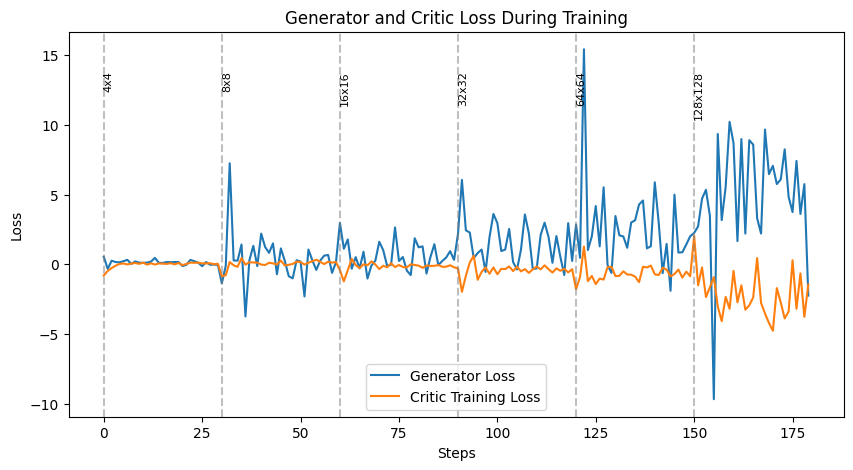

In [17]:
import matplotlib.pyplot as plt

# Define the step indices where image sizes changed
image_size_steps = [0, 30, 60, 90, 120, 150]  # Modify based on your actual step indices
image_sizes = ["4x4", "8x8", "16x16", "32x32", "64x64", "128x128"]

plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(critic_losses, label="Critic Training Loss")

# Add vertical lines and labels for image size transitions
for step, size in zip(image_size_steps, image_sizes):
    plt.axvline(x=step, color='gray', linestyle='--', alpha=0.5)
    plt.text(step, max(max(gen_losses), max(critic_losses)) * 0.9, size, 
             rotation=90, verticalalignment='top', fontsize=8, color='black')

plt.title("Generator and Critic Loss During Training")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("logs/progan/20250127-002255/" + "ProGAN loss curves.png")  # Save the loss plot
plt.show()


In [10]:
# def convert_images_to_gif(input_folder, output_gif_path):
#     images = []
#     for filename in os.listdir(input_folder):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             img_path = os.path.join(input_folder, filename)
#             img = Image.open(img_path)
#             images.append(img)
#     images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=100, loop=1)


# convert_images_to_gif(log_folder_name + "training", log_folder_name + "training.gif")

## Inference

In [11]:
# gen = Generator(
#     config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
# ).to(config.DEVICE)
# opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
# load_checkpoint(
#         config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,
#     )

In [12]:
import matplotlib.pyplot as plt

image_size = 128
num_images = 16
noise = torch.randn(num_images, config.Z_DIM, 1, 1).to(config.DEVICE)
gen.eval()
with torch.no_grad():
    fake = gen(noise, 0.5, int(log2(img_size / 4))).squeeze() * 0.5 + 0.5
    imgs = fake.cpu().detach().permute(0,2,3,1)

plt.figure(figsize=(10, 10))
for i in range(len(imgs)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    # plt.tight_layout()

ModuleNotFoundError: No module named 'matplotlib'